In [182]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#  Holt-Winters ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
import statsmodels.api as sm
import pmdarima as pm
import sklearn.metrics as skmetrics

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

/var/folders/jq/7jhfmgd96z7d57jn6j0zc2nr0000gn/T/ipykernel_54793/3179699621.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [34]:
df_zillow = pd.read_csv('zillow-carlifornia.csv', parse_dates=['Date'])
df_zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [48]:
df_test = pd.read_csv('test.csv', parse_dates=['Month'])
df_test.rename(columns={'Month':'Date'},inplace=True)

In [35]:
df_zillow.rename(columns={'MedianSoldPrice_AllHomes.California':'sold_price'},inplace=True)

In [36]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               107 non-null    datetime64[ns]
 1   sold_price         95 non-null     float64       
 2   MedianMortageRate  107 non-null    float64       
 3   UnemploymentRate   107 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.5 KB


In [20]:
pd.read_csv('test.csv')

,Month,Median House Price
0,2016-01-31,476250
1,2016-02-29,466000
2,2016-03-31,485000
3,2016-04-30,501000
4,2016-05-31,501000
5,2016-06-30,505000
6,2016-07-31,507000
7,2016-08-31,510000
8,2016-09-30,510000
9,2016-10-31,523000


In [67]:
train = df_zillow[df_zillow.Date<'2016-01-31']
test = df_zillow[df_zillow.Date>='2016-01-31']
test['sold_price'] = df_test['Median House Price'].values

/var/folders/jq/7jhfmgd96z7d57jn6j0zc2nr0000gn/T/ipykernel_54793/1677068951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sold_price'] = df_test['Median House Price'].values


In [68]:
test

,Date,sold_price,MedianMortageRate,UnemploymentRate
95,2016-01-31,476250,3.91,5.0
96,2016-02-29,466000,3.96,4.9
97,2016-03-31,485000,3.60,5.0
98,2016-04-30,501000,3.60,5.0
99,2016-05-31,501000,3.59,4.8
100,2016-06-30,505000,3.59,4.8
101,2016-07-31,507000,3.46,4.9
102,2016-08-31,510000,3.46,4.8
103,2016-09-30,510000,3.42,5.0
104,2016-10-31,523000,3.36,5.0


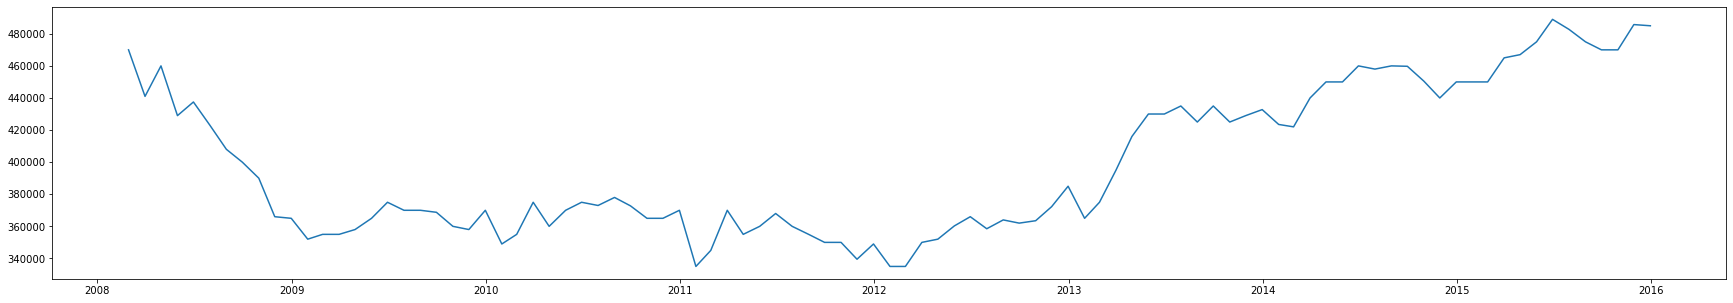

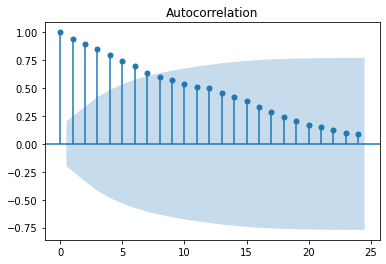

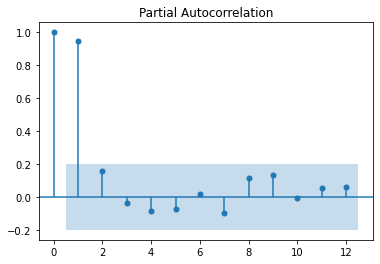

In [97]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)
ax.plot(train.set_index(['Date']).sold_price)
plt.show()
plot_acf(train.sold_price,lags=24) 
plt.show()
plot_pacf(train.sold_price,lags=12) 
plt.show()


In [72]:
dftest = adfuller(train.sold_price)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


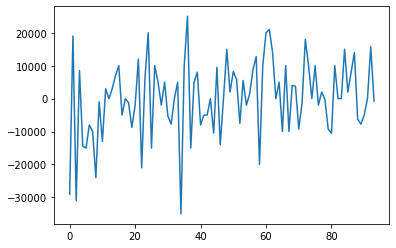

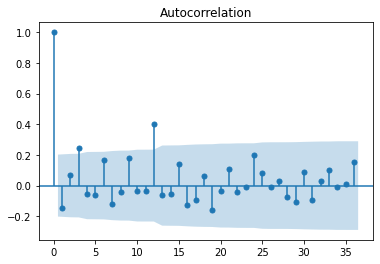

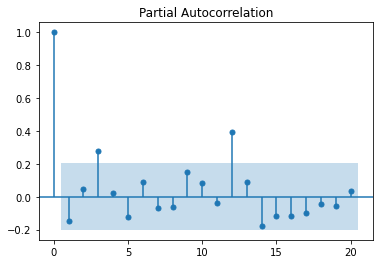

In [102]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

# fit a trend only model 
# determine d
d1 = diff(train.sold_price, 1)
plt.plot(d1)
plot_acf(d1,lags=36) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()
#flat already

In [77]:
from datetime import datetime as dt
train.Date.dt.year

0     2008
1     2008
2     2008
3     2008
4     2008
      ... 
90    2015
91    2015
92    2015
93    2015
94    2015
Name: Date, Length: 95, dtype: int64

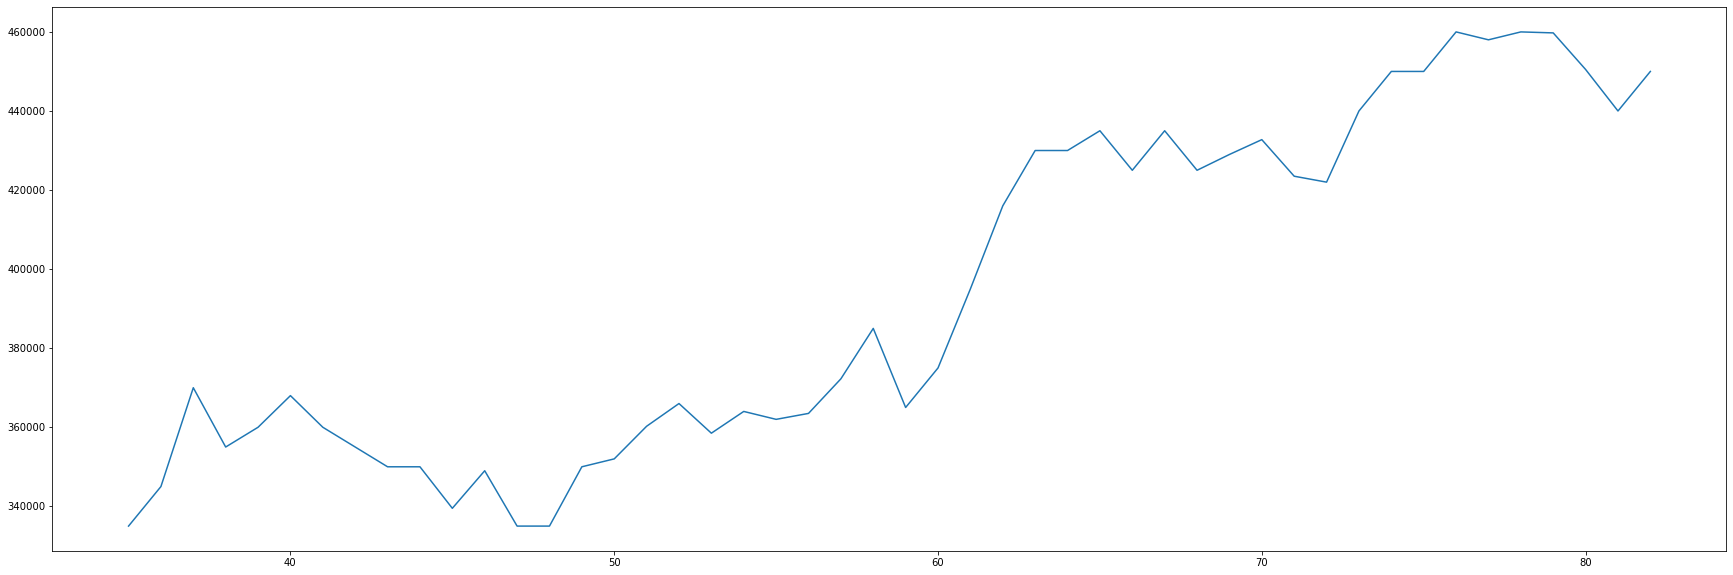

In [93]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)
ax.plot(train[(train.Date.dt.year > 2010) & (train.Date.dt.year < 2015)].sold_price)
plt.show()

In [40]:
train.head()

,Date,sold_price,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [41]:
train.iloc[:,1:]

,sold_price,MedianMortageRate,UnemploymentRate
0,470000.0,5.29,6.3
1,441000.0,5.44,6.2
2,460000.0,5.42,6.4
3,429000.0,5.47,6.3
4,437500.0,5.60,6.2
...,...,...,...
90,475000.0,3.95,5.2
91,470000.0,3.87,5.1
92,470000.0,3.80,5.0
93,485750.0,3.69,5.0


In [155]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

train_sc = sc.fit_transform(train.iloc[:,1:].values )
test_sc = sc.transform(test.iloc[:,1:].values )

In [160]:
df_train_sc = pd.DataFrame(train_sc,columns=['sold_price','MedianMortageRate','UnemploymentRate'])
df_train_sc

,sold_price,MedianMortageRate,UnemploymentRate
0,0.876623,0.729927,0.317073
1,0.688312,0.784672,0.292683
2,0.811688,0.777372,0.341463
3,0.610390,0.795620,0.317073
4,0.665584,0.843066,0.292683
...,...,...,...
90,0.909091,0.240876,0.048780
91,0.876623,0.211679,0.024390
92,0.876623,0.186131,0.000000
93,0.978896,0.145985,0.000000


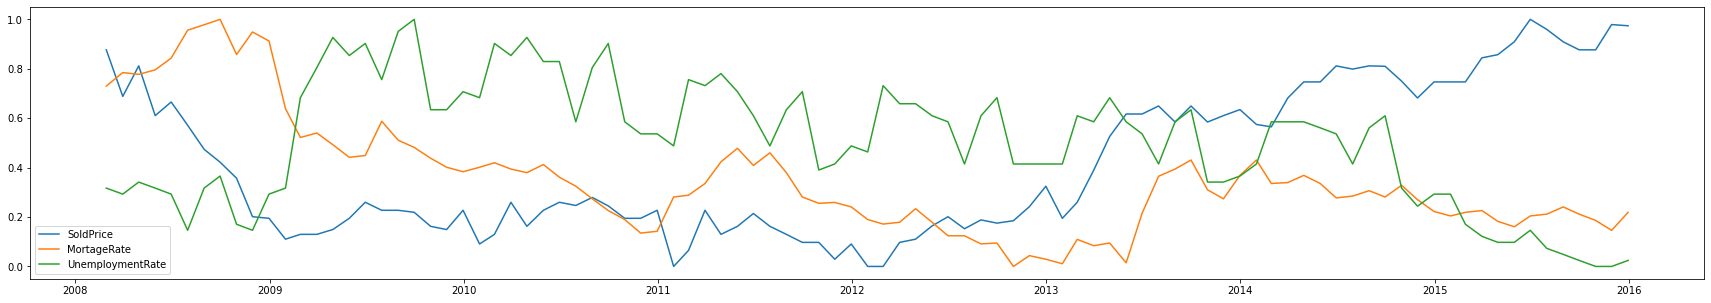

In [170]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)
ax.plot(df_train_sc.set_index(train['Date']).sold_price, label = 'SoldPrice')
ax.plot(df_train_sc.set_index(train['Date']).MedianMortageRate, label = 'MortageRate')
ax.plot(df_train_sc.set_index(train['Date']).UnemploymentRate, label = 'UnemploymentRate')
ax.legend()
plt.show()


In [156]:
model = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-215.712, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-238.288, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.241, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-217.701, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-215.233, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-236.319, Time=0.52 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-236.333, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-233.728, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-234.368, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-237.576, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-240.100, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-213.848, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-238.185, Time=0.77 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-238.221, Time=0.33 sec
 ARIMA(2,1,0)(0,0,1

In [128]:
sc.inverse_transform(y_pred_)

array([[4.79028204e+05, 5.85257973e+00, 8.83451711e+00],
       [4.83440378e+05, 5.93108206e+00, 8.95198410e+00],
       [5.06710078e+05, 6.34510139e+00, 9.57150208e+00],
       [5.13337921e+05, 6.46302535e+00, 9.74795764e+00],
       [5.24199873e+05, 6.65628346e+00, 1.00371395e+01],
       [5.38710398e+05, 6.91445773e+00, 1.04234586e+01],
       [5.44742322e+05, 7.02177897e+00, 1.05840488e+01],
       [5.40424739e+05, 6.94495964e+00, 1.04691002e+01],
       [5.43721426e+05, 7.00361499e+00, 1.05568691e+01],
       [5.47612788e+05, 7.07285091e+00, 1.06604703e+01],
       [5.54726006e+05, 7.19941075e+00, 1.08498482e+01],
       [5.57359541e+05, 7.24626715e+00, 1.09199618e+01]])

In [142]:
y_pred_

array([[0.93524808, 0.93524808, 0.93524808],
       [0.96389856, 0.96389856, 0.96389856],
       [1.11500051, 1.11500051, 1.11500051],
       [1.15803845, 1.15803845, 1.15803845],
       [1.22857061, 1.22857061, 1.22857061],
       [1.32279479, 1.32279479, 1.32279479],
       [1.36196313, 1.36196313, 1.36196313],
       [1.33392687, 1.33392687, 1.33392687],
       [1.35533394, 1.35533394, 1.35533394],
       [1.38060252, 1.38060252, 1.38060252],
       [1.42679224, 1.42679224, 1.42679224],
       [1.44389312, 1.44389312, 1.44389312]])

In [173]:
y_pred = model.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [158]:
### RMSE
print(np.sqrt(mean_squared_error(test.sold_price, y_pred_inv)))

16647.377977713215


In [171]:
model2 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:2], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-215.475, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.081, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.407, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-217.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-215.420, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-237.142, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-237.170, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-233.959, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-235.225, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-238.215, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-240.480, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-213.886, Time=0.07 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-238.579, Time=0.60 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-238.623, Time=0.29 sec
 ARIMA(2,1,0)(0,0,1

In [175]:
y_pred2 = model2.predict(n_periods=len(test_sc),X=test_sc[:,1:2]).reshape(-1,1)
y_pred2_ = np.repeat(y_pred2,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv2 = sc.inverse_transform(y_pred2_)[:,0]# inverset the pred and take the first column (gdp)

In [176]:
### RMSE
print(mean(test.sold_price, y_pred_inv2)))

15904.474247912052


In [183]:
print(mean_absolute_percentage_error(test.sold_price, y_pred_inv2))

0.029518178649251586


In [239]:
model3 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,2:3], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-217.045, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-238.335, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-234.637, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-219.015, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-216.832, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-236.335, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-236.335, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-235.137, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-234.352, Time=0.51 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-237.478, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-238.326, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-237.008, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-237.561, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-242.921, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0

In [179]:
y_pred3 = model3.predict(n_periods=len(test_sc),X=test_sc[:,0:1]).reshape(-1,1)
y_pred3_ = np.repeat(y_pred2,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv3 = sc.inverse_transform(y_pred3_)[:,0]# inverset the pred and take the first column (gdp)

In [180]:
### RMSE
print(np.sqrt(mean_squared_error(test.sold_price, y_pred_inv3)))

15904.474247912052


In [ ]:
def evaluate_sarima_model(X, trend_order, seasonal_order, split):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    return mape

In [231]:
def evaluate_sarimax_model(data1, data2, trend_order, seasonal_order, split):
    train_size = int(len(data1) * split)
    sc1 = MinMaxScaler(feature_range = (0,1))
    sc2 = MinMaxScaler(feature_range = (0,1))
    
    train_data1, test_data1 = data1[0:train_size], data1.iloc[train_size:]
    train_data2, test_data2 = data2[0:train_size], data2.iloc[train_size:]
    
    sc1.fit(train_data1.iloc[:train_size].values.reshape(-1, 1))
    sc2.fit(train_data2.iloc[:train_size].values)
    
    data1_sc = sc1.fit_transform(data1.values.reshape(-1, 1))
    data2_sc = sc2.fit_transform(data2.values)
    
    predictions = list()
    for t in tqdm(range(len(test_data1))):
        model = sm.tsa.statespace.SARIMAX(data1_sc[:train_size+t],exog=data2_sc[:train_size+t,:], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        y_hat = np.asanyarray(model_fit.forecast(exog=data2_sc[train_size+t,:]))[0] #predict one step
        #print(yhat, data1_sc[train_size+t])
        y_pred_inv = sc1.inverse_transform(y_hat.reshape(1, -1))[:,0]
        predictions.append(y_pred_inv) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test_data1).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    #y_pred2 = model2.predict(n_periods=len(test_sc),X=test_sc[:,1:2]).reshape(-1,1)
#     y_pred_ = np.repeat(predictions,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
#     y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)
    rmse = np.sqrt(skmetrics.mean_squared_error(test_data1, predictions))
    mape = mean_absolute_percentage_error(test_data1, predictions)
    return mape

In [232]:
#(1,1,2)(1,0,0)[12]
evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,2:], trend_order=(1,1,2), seasonal_order=(1,0,0,12), split=0.8)

  0%|                                                    | 0/19 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24299D+00    |proj g|=  1.75920D+00

At iterate    5    f= -1.25126D+00    |proj g|=  9.43471D-01

At iterate   10    f= -1.31215D+00    |proj g|=  6.55789D-01

At iterate   15    f= -1.33591D+00    |proj g|=  2.74138D-01

At iterate   20    f= -1.35721D+00    |proj g|=  4.77945D-01

At iterate   25    f= -1.36121D+00    |proj g|=  1.99571D-01

At iterate   30    f= -1.36277D+00    |proj g|=  4.50329D-02

At iterate   35    f= -1.36417D+00    |proj g|=  1.28064D-02

At iterate   40    f= -1.36434D+00    |proj g|=  3.29686D-03


  5%|██▎                                         | 1/19 [00:00<00:04,  3.70it/s]


At iterate   45    f= -1.36434D+00    |proj g|=  1.62695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     58      1     0     0   6.104D-05  -1.364D+00
  F =  -1.3643441015909263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25074D+00    |proj g|=  1.94651D+00

At iterate    5    f= -1.31275D+00    |proj g|=  1.02221D+00

At iterate   10    f= -1.32403D+00    |proj g|=  1.72093D+00

At iter

 This problem is unconstrained.
 11%|████▋                                       | 2/19 [00:00<00:04,  4.18it/s]


At iterate   35    f= -1.37135D+00    |proj g|=  2.79000D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     50      1     0     0   3.237D-04  -1.371D+00
  F =  -1.3713573299009336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25694D+00    |proj g|=  1.91006D+00

At iterate    5    f= -1.31204D+00    |proj g|=  2.16025D+00

At iterate   10    f= -1.34170D+00    |proj g|=  5.35499D-01

At iter

 This problem is unconstrained.
 16%|██████▉                                     | 3/19 [00:00<00:03,  4.41it/s]


At iterate   35    f= -1.37716D+00    |proj g|=  2.05388D-03

At iterate   40    f= -1.37716D+00    |proj g|=  1.97050D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     49      1     0     0   1.971D-03  -1.377D+00
  F =  -1.3771601298957388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26156D+00    |proj g|=  1.82484D+00

At iterate    5    f= -1.27266D+00    |proj g|=  1.29836D+00

At iter

 This problem is unconstrained.
 21%|█████████▎                                  | 4/19 [00:00<00:03,  4.35it/s]


At iterate   40    f= -1.37934D+00    |proj g|=  1.20404D-03

At iterate   45    f= -1.37934D+00    |proj g|=  9.83496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     56      1     0     0   5.430D-04  -1.379D+00
  F =  -1.3793414909298864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26646D+00    |proj g|=  1.75412D+00

At iterate    5    f= -1.27550D+00    |proj g|=  1.10836D+00

At iter

 This problem is unconstrained.
/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|███████████▌                                | 5/19 [00:01<00:03,  4.21it/s]


At iterate   35    f= -1.38392D+00    |proj g|=  9.65321D-02

At iterate   40    f= -1.38490D+00    |proj g|=  5.37765D-02

At iterate   45    f= -1.38493D+00    |proj g|=  4.00442D-02

At iterate   50    f= -1.38494D+00    |proj g|=  3.95754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   3.958D-03  -1.385D+00
  F =  -1.3849424146281388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 32%|█████████████▉                              | 6/19 [00:01<00:02,  4.34it/s]


At iterate   25    f= -1.38732D+00    |proj g|=  4.17929D-02

At iterate   30    f= -1.39009D+00    |proj g|=  7.21552D-02

At iterate   35    f= -1.39137D+00    |proj g|=  1.92422D-01

At iterate   40    f= -1.39163D+00    |proj g|=  1.20072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     49      1     0     0   7.999D-04  -1.392D+00
  F =  -1.3916321935387992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 37%|████████████████▏                           | 7/19 [00:01<00:02,  4.28it/s]


At iterate   25    f= -1.37944D+00    |proj g|=  1.09435D-01

At iterate   30    f= -1.38378D+00    |proj g|=  1.78420D-01

At iterate   35    f= -1.38396D+00    |proj g|=  1.65547D-03

At iterate   40    f= -1.38396D+00    |proj g|=  7.66866D-04

At iterate   45    f= -1.38396D+00    |proj g|=  2.17027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     56      1     0     0   2.170D-04  -1.384D+00
  F =  -1.3839572624401417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 42%|██████████████████▌                         | 8/19 [00:01<00:02,  4.20it/s]


At iterate   20    f= -1.38632D+00    |proj g|=  3.51745D-02

At iterate   25    f= -1.38885D+00    |proj g|=  1.48589D-01

At iterate   30    f= -1.39053D+00    |proj g|=  8.12883D-03

At iterate   35    f= -1.39059D+00    |proj g|=  1.07520D-03

At iterate   40    f= -1.39059D+00    |proj g|=  1.39759D-02

At iterate   45    f= -1.39060D+00    |proj g|=  6.78729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     57      1     0     0   2.519D-03  -1.391D+00
  F =  -1.3906004195598713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -1.34444D+00    |proj g|=  6.92995D-01

At iterate   15    f= -1.36046D+00    |proj g|=  3.94988D-01

At iterate   20    f= -1.38292D+00    |proj g|=  3.35927D-01

At iterate   25    f= -1.38455D+00    |proj g|=  3.51397D-01

At iterate   30    f= -1.38945D+00    |proj g|=  4.91452D-02

At iterate   35    f= -1.38978D+00    |proj g|=  1.55714D-02

At iterate   40    f= -1.38991D+00    |proj g|=  4.89283D-02

At iterate   45    f= -1.39025D+00    |proj g|=  5.25252D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 47%|████████████████████▊                       | 9/19 [00:02<00:02,  3.76it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     76      1     0     0   9.040D-04  -1.390D+00
  F =  -1.3902552919967925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28480D+00    |proj g|=  1.65329D+00

At iterate    5    f= -1.29243D+00    |proj g|=  1.02631D+00

At iterate   10    f= -1.34887D+00    |proj g|=  4.46119D-01

At iterate   15    f= -1.36279D+00    |proj g|=  2.35568D-01

At iter

 This problem is unconstrained.
 53%|██████████████████████▋                    | 10/19 [00:02<00:02,  3.83it/s]

At iterate   35    f= -1.38956D+00    |proj g|=  1.69274D-02

At iterate   40    f= -1.38956D+00    |proj g|=  1.76749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     56      1     0     0   3.055D-03  -1.390D+00
  F =  -1.3895646005543558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28719D+00    |proj g|=  1.95261D+00

At iterate    5    f= -1.35503D+00    |proj g|=  1.08597D+00

At itera

 This problem is unconstrained.
 58%|████████████████████████▉                  | 11/19 [00:02<00:01,  4.00it/s]


At iterate   30    f= -1.39493D+00    |proj g|=  3.54789D-02

At iterate   35    f= -1.39497D+00    |proj g|=  1.48365D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     50      1     0     0   2.087D-04  -1.395D+00
  F =  -1.3949729082576543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29242D+00    |proj g|=  1.92725D+00

At iterate    5    f= -1.31537D+00    |proj g|=  3.29842D+00

At iter

 This problem is unconstrained.
 63%|███████████████████████████▏               | 12/19 [00:02<00:01,  3.98it/s]


At iterate   30    f= -1.39235D+00    |proj g|=  8.56410D-01

At iterate   35    f= -1.39481D+00    |proj g|=  7.77706D-02

At iterate   40    f= -1.39502D+00    |proj g|=  1.03015D-02

At iterate   45    f= -1.39519D+00    |proj g|=  3.25234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     57      1     0     0   9.856D-04  -1.395D+00
  F =  -1.3951984081451743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 68%|█████████████████████████████▍             | 13/19 [00:03<00:01,  3.92it/s]


At iterate   20    f= -1.37458D+00    |proj g|=  5.00956D-01

At iterate   25    f= -1.39451D+00    |proj g|=  4.54955D-01

At iterate   30    f= -1.39970D+00    |proj g|=  4.48849D-02

At iterate   35    f= -1.40099D+00    |proj g|=  1.22732D-01

At iterate   40    f= -1.40113D+00    |proj g|=  3.00257D-03

At iterate   45    f= -1.40113D+00    |proj g|=  6.17434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     59      1     0     0   1.165D-03  -1.401D+00
  F =  -1.4011340082837012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -1.35047D+00    |proj g|=  7.03861D-01

At iterate   15    f= -1.36499D+00    |proj g|=  1.68860D-01

At iterate   20    f= -1.37521D+00    |proj g|=  3.11859D-01

At iterate   25    f= -1.38357D+00    |proj g|=  1.23094D+00

At iterate   30    f= -1.39218D+00    |proj g|=  5.42757D-02

At iterate   35    f= -1.40092D+00    |proj g|=  2.77695D-01

At iterate   40    f= -1.40187D+00    |proj g|=  5.11066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     69      1     0     0   6.308D-04  -1.402D+00
  F =  -1.4018819726125893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 74%|███████████████████████████████▋           | 14/19 [00:03<00:01,  3.80it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30089D+00    |proj g|=  2.08550D+00

At iterate    5    f= -1.32555D+00    |proj g|=  3.27753D+00

At iterate   10    f= -1.36397D+00    |proj g|=  9.93727D-01

At iterate   15    f= -1.36731D+00    |proj g|=  4.73454D-01

At iterate   20    f= -1.37839D+00    |proj g|=  2.49697D-01

At iterate   25    f= -1.39377D+00    |proj g|=  2.06582D-01

At iterate   30    f= -1.40116D+00    |proj g|=  1.17615D-01

At iterate   35    f= -1.40651D+00    |proj g|=  3.00329D-02

At iterate   40    f= -1.40661D+00    |proj g|=  4.99516D-02


 79%|█████████████████████████████████▉         | 15/19 [00:03<00:01,  3.79it/s]


At iterate   45    f= -1.40662D+00    |proj g|=  3.59082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     59      1     0     0   6.139D-04  -1.407D+00
  F =  -1.4066194187053458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30069D+00    |proj g|=  1.98535D+00

At iterate    5    f= -1.33411D+00    |proj g|=  2.50434D+00

At iterate   10    f= -1.35565D+00    |proj g|=  7.00353D-01

At iter

 This problem is unconstrained.
 84%|████████████████████████████████████▏      | 16/19 [00:04<00:00,  3.79it/s]


At iterate   35    f= -1.40079D+00    |proj g|=  1.78010D-01

At iterate   40    f= -1.40323D+00    |proj g|=  5.40184D-02

At iterate   45    f= -1.40325D+00    |proj g|=  5.23111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     58      1     0     0   5.231D-05  -1.403D+00
  F =  -1.4032494544870764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30491D+00    |proj g|=  1.97725D+00

At iter

 This problem is unconstrained.
 89%|██████████████████████████████████████▍    | 17/19 [00:04<00:00,  3.77it/s]


At iterate   25    f= -1.37670D+00    |proj g|=  1.05049D+00

At iterate   30    f= -1.38958D+00    |proj g|=  1.52353D+00

At iterate   35    f= -1.39733D+00    |proj g|=  9.75524D-02

At iterate   40    f= -1.40433D+00    |proj g|=  8.64196D-02

At iterate   45    f= -1.40442D+00    |proj g|=  8.93050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     59      1     0     0   1.063D-04  -1.404D+00
  F =  -1.4044233929247232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 95%|████████████████████████████████████████▋  | 18/19 [00:04<00:00,  3.74it/s]


At iterate   10    f= -1.36000D+00    |proj g|=  1.45043D+00

At iterate   15    f= -1.36547D+00    |proj g|=  3.76963D-01

At iterate   20    f= -1.37591D+00    |proj g|=  5.41799D-01

At iterate   25    f= -1.38946D+00    |proj g|=  1.57722D-01

At iterate   30    f= -1.40176D+00    |proj g|=  2.17303D-01

At iterate   35    f= -1.41000D+00    |proj g|=  8.81930D-02

At iterate   40    f= -1.41009D+00    |proj g|=  1.13433D-03

At iterate   45    f= -1.41009D+00    |proj g|=  8.14546D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     58      1     0     0   8.145D-05  -1.410D+00
  F =  -1.41009342997

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29116D+00    |proj g|=  1.52676D+00

At iterate    5    f= -1.29700D+00    |proj g|=  8.51696D-01

At iterate   10    f= -1.33261D+00    |proj g|=  5.66403D-01

At iterate   15    f= -1.33348D+00    |proj g|=  9.37957D-02

At iterate   20    f= -1.33632D+00    |proj g|=  1.09890D-01

At iterate   25    f= -1.34967D+00    |proj g|=  9.95872D-02

At iterate   30    f= -1.37145D+00    |proj g|=  7.78949D-02

At iterate   35    f= -1.37354D+00    |proj g|=  6.14809D-03


100%|███████████████████████████████████████████| 19/19 [00:04<00:00,  3.95it/s]


At iterate   40    f= -1.37354D+00    |proj g|=  2.63222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     52      1     0     0   7.994D-04  -1.374D+00
  F =  -1.3735404767915735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


0.015501798508612741

In [236]:
#(1,1,2)(1,0,0)[12] 
evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,2:3], trend_order=(1,1,2), seasonal_order=(1,0,0,12), split=0.8)

  5%|██▎                                         | 1/19 [00:00<00:03,  4.51it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24763D+00    |proj g|=  2.10232D+00

At iterate    5    f= -1.25938D+00    |proj g|=  1.44167D+00

At iterate   10    f= -1.30117D+00    |proj g|=  1.33154D-01

At iterate   15    f= -1.31015D+00    |proj g|=  1.82656D+00

At iterate   20    f= -1.31902D+00    |proj g|=  9.86313D-02

At iterate   25    f= -1.33906D+00    |proj g|=  2.41732D+00

At iterate   30    f= -1.35548D+00    |proj g|=  2.56416D-01

At iterate   35    f= -1.36075D+00    |proj g|=  8.58640D-02

At iterate   40    f= -1.36358D+00    |proj g|=  1.18635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 11%|████▋                                       | 2/19 [00:00<00:03,  5.04it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25491D+00    |proj g|=  2.24744D+00

At iterate    5    f= -1.27102D+00    |proj g|=  2.25636D+00

At iterate   10    f= -1.31042D+00    |proj g|=  6.52003D-01

At iterate   15    f= -1.32726D+00    |proj g|=  2.57217D-01

At iterate   20    f= -1.33878D+00    |proj g|=  7.88895D-01

At iterate   25    f= -1.36438D+00    |proj g|=  3.78791D-01

At iterate   30    f= -1.36755D+00    |proj g|=  1.76229D-01

At iterate   35    f= -1.37045D+00    |proj g|=  2.03082D-02

At iterate   40    f= -1.37058D+00    |proj g|=  8.79443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 16%|██████▉                                     | 3/19 [00:00<00:03,  5.31it/s] This problem is unconstrained.



At iterate    5    f= -1.27803D+00    |proj g|=  2.42482D+00

At iterate   10    f= -1.31424D+00    |proj g|=  4.21610D-01

At iterate   15    f= -1.33145D+00    |proj g|=  8.61233D-01

At iterate   20    f= -1.33802D+00    |proj g|=  9.41285D-01

At iterate   25    f= -1.36626D+00    |proj g|=  3.24725D-01

At iterate   30    f= -1.37381D+00    |proj g|=  3.57462D-02

At iterate   35    f= -1.37631D+00    |proj g|=  1.27631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     46      1     0     0   5.492D-04  -1.376D+00
  F =  -1.3763090799957376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 21%|█████████▎                                  | 4/19 [00:00<00:02,  5.52it/s] This problem is unconstrained.



At iterate   15    f= -1.34031D+00    |proj g|=  1.17479D-01

At iterate   20    f= -1.37152D+00    |proj g|=  1.01837D-01

At iterate   25    f= -1.37551D+00    |proj g|=  3.93509D-02

At iterate   30    f= -1.37841D+00    |proj g|=  3.35124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     42      1     0     0   2.563D-03  -1.378D+00
  F =  -1.3784918589535087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 26%|███████████▌                                | 5/19 [00:00<00:02,  5.35it/s] This problem is unconstrained.


At iterate   25    f= -1.38056D+00    |proj g|=  1.24251D-01

At iterate   30    f= -1.38234D+00    |proj g|=  2.35595D-01

At iterate   35    f= -1.38422D+00    |proj g|=  2.04609D-02

At iterate   40    f= -1.38422D+00    |proj g|=  1.90093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     51      1     0     0   2.732D-04  -1.384D+00
  F =  -1.3842181838161192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|█████████████▉                              | 6/19 [00:01<00:02,  4.98it/s]


At iterate   25    f= -1.38608D+00    |proj g|=  3.81635D-01

At iterate   30    f= -1.38760D+00    |proj g|=  7.75466D-02

At iterate   35    f= -1.38988D+00    |proj g|=  5.86915D-01

At iterate   40    f= -1.39071D+00    |proj g|=  3.81261D-02

At iterate   45    f= -1.39073D+00    |proj g|=  2.16447D-03

At iterate   50    f= -1.39074D+00    |proj g|=  2.27254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.273D-04  -1.391D+00
  F =  -1.3907351880571723     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 37%|████████████████▏                           | 7/19 [00:01<00:02,  4.30it/s]


At iterate   25    f= -1.37622D+00    |proj g|=  4.76693D-02

At iterate   30    f= -1.38111D+00    |proj g|=  7.50908D-02

At iterate   35    f= -1.38171D+00    |proj g|=  7.63561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     85      2     0     0   1.089D-04  -1.382D+00
  F =  -1.3817230837675967     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27531D+00    |proj g|=  2.08194D+00

At iterate    5    f= -1.28371D+00    |proj g|=  8.82109D-01

At iterate   10    f= -1.32558D+00    |proj g|=  4.13300D-01

At iterate   15    f= -1.33187D+00    |proj g|=  1.77416D+00

At iterate   20    f= -1.34683D+00    |proj g|=  2.75229D-01

At iterate   25    f= -1.38254D+00    |proj g|=  1.86628D-01

At iterate   30    f= -1.38517D+00    |proj g|=  6.45182D-01

At iterate   35    f= -1.38830D+00    |proj g|=  3.07557D-03

At iterate   40    f= -1.38832D+00    |proj g|=  4.78289D-02

At iterate   45    f= -1.38832D+00    |proj g|=  5.03936D-03


 47%|████████████████████▊                       | 9/19 [00:01<00:02,  4.62it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58      1     0     0   2.072D-04  -1.388D+00
  F =  -1.3883227774535156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27962D+00    |proj g|=  2.01290D+00

At iterate    5    f= -1.32136D+00    |proj g|=  1.52021D+00

At iterate   10    f= -1.34938D+00    |proj g|=  3.22345D-01

At iterate   15    f= -1.36653D+00    |proj g|=  5.49932D-01

At iter

 This problem is unconstrained.
 53%|██████████████████████▋                    | 10/19 [00:02<00:01,  4.76it/s] This problem is unconstrained.



At iterate    5    f= -1.31025D+00    |proj g|=  2.73769D+00

At iterate   10    f= -1.34808D+00    |proj g|=  1.16143D+00

At iterate   15    f= -1.35346D+00    |proj g|=  7.53190D-01

At iterate   20    f= -1.37093D+00    |proj g|=  2.46271D-01

At iterate   25    f= -1.37599D+00    |proj g|=  3.62370D-01

At iterate   30    f= -1.38188D+00    |proj g|=  2.11209D-01

At iterate   35    f= -1.38812D+00    |proj g|=  7.84687D-02

At iterate   40    f= -1.38816D+00    |proj g|=  1.48904D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     49      1     0     0   1.718D-03  -1.388D+00
  F =  -1.38815985582

 58%|████████████████████████▉                  | 11/19 [00:02<00:01,  4.48it/s]


At iterate    5    f= -1.30133D+00    |proj g|=  2.21610D-01

At iterate   10    f= -1.33707D+00    |proj g|=  9.13240D-01

At iterate   15    f= -1.34440D+00    |proj g|=  1.70748D+00

At iterate   20    f= -1.35658D+00    |proj g|=  6.10304D-01

At iterate   25    f= -1.37738D+00    |proj g|=  3.65675D-01

At iterate   30    f= -1.38370D+00    |proj g|=  1.16016D+00

At iterate   35    f= -1.38847D+00    |proj g|=  2.38039D-01

At iterate   40    f= -1.39378D+00    |proj g|=  1.59544D-01

At iterate   45    f= -1.39394D+00    |proj g|=  1.80244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     65   

 This problem is unconstrained.
 63%|███████████████████████████▏               | 12/19 [00:02<00:01,  4.67it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29455D+00    |proj g|=  2.25666D+00

At iterate    5    f= -1.35493D+00    |proj g|=  9.57487D-01

At iterate   10    f= -1.38017D+00    |proj g|=  1.23248D+00

At iterate   15    f= -1.38511D+00    |proj g|=  5.71162D-02

At iterate   20    f= -1.39213D+00    |proj g|=  3.24248D-01

At iterate   25    f= -1.39349D+00    |proj g|=  1.08291D-01

At iterate   30    f= -1.39352D+00    |proj g|=  6.92977D-03

At iterate   35    f= -1.39352D+00    |proj g|=  3.08002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 68%|█████████████████████████████▍             | 13/19 [00:02<00:01,  4.76it/s] This problem is unconstrained.



At iterate    5    f= -1.32981D+00    |proj g|=  2.48187D+00

At iterate   10    f= -1.36701D+00    |proj g|=  6.32718D-02

At iterate   15    f= -1.37655D+00    |proj g|=  1.29530D+00

At iterate   20    f= -1.39442D+00    |proj g|=  6.63051D-01

At iterate   25    f= -1.39850D+00    |proj g|=  7.62910D-02

At iterate   30    f= -1.39930D+00    |proj g|=  2.30280D-02

At iterate   35    f= -1.39935D+00    |proj g|=  4.02917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     50      1     0     0   4.705D-03  -1.399D+00
  F =  -1.3993475218244982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 74%|███████████████████████████████▋           | 14/19 [00:02<00:01,  4.75it/s]


At iterate   10    f= -1.34528D+00    |proj g|=  8.95320D-01

At iterate   15    f= -1.35876D+00    |proj g|=  6.42702D-02

At iterate   20    f= -1.36374D+00    |proj g|=  6.93485D-01

At iterate   25    f= -1.38852D+00    |proj g|=  1.61322D-01

At iterate   30    f= -1.39059D+00    |proj g|=  1.33976D-01

At iterate   35    f= -1.39547D+00    |proj g|=  8.14070D-02

At iterate   40    f= -1.39554D+00    |proj g|=  2.46281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     52      1     0     0   1.831D-04  -1.396D+00
  F =  -1.3955391244760542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 79%|█████████████████████████████████▉         | 15/19 [00:03<00:00,  4.92it/s] This problem is unconstrained.



At iterate   10    f= -1.36406D+00    |proj g|=  7.88775D-01

At iterate   15    f= -1.37733D+00    |proj g|=  2.66334D-01

At iterate   20    f= -1.38985D+00    |proj g|=  1.27881D-01

At iterate   25    f= -1.39509D+00    |proj g|=  1.90973D-01

At iterate   30    f= -1.40083D+00    |proj g|=  1.12125D-01

At iterate   35    f= -1.40102D+00    |proj g|=  7.05241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     46      1     0     0   5.341D-05  -1.401D+00
  F =  -1.4010218163807937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 84%|████████████████████████████████████▏      | 16/19 [00:03<00:00,  4.42it/s]


At iterate   15    f= -1.35556D+00    |proj g|=  3.72291D-01

At iterate   20    f= -1.36678D+00    |proj g|=  1.53274D+00

At iterate   25    f= -1.37901D+00    |proj g|=  6.81608D-02

At iterate   30    f= -1.39222D+00    |proj g|=  1.06938D-01

At iterate   35    f= -1.39495D+00    |proj g|=  7.83777D-02

At iterate   40    f= -1.39499D+00    |proj g|=  2.94323D-04
  ys=-1.183E-08  -gs= 1.875E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     71      1     1     0   7.019D-04  -1.395D+00
  F =  -1.3949944324535168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.
 89%|██████████████████████████████████████▍    | 17/19 [00:03<00:00,  4.31it/s]


At iterate    5    f= -1.34250D+00    |proj g|=  2.64007D-01

At iterate   10    f= -1.35426D+00    |proj g|=  6.41410D-02

At iterate   15    f= -1.35636D+00    |proj g|=  7.83765D-01

At iterate   20    f= -1.36160D+00    |proj g|=  1.07893D-01

At iterate   25    f= -1.37764D+00    |proj g|=  1.52412D-01

At iterate   30    f= -1.38659D+00    |proj g|=  1.01594D+00

At iterate   35    f= -1.39411D+00    |proj g|=  3.16973D-02

At iterate   40    f= -1.39423D+00    |proj g|=  4.13724D-02

At iterate   45    f= -1.39424D+00    |proj g|=  6.94159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30816D+00    |proj g|=  2.20496D+00

At iterate    5    f= -1.32130D+00    |proj g|=  1.99278D+00

At iterate   10    f= -1.34518D+00    |proj g|=  2.42778D-01

At iterate   15    f= -1.35393D+00    |proj g|=  1.43176D+00

At iterate   20    f= -1.36373D+00    |proj g|=  2.05397D-01

At iterate   25    f= -1.37946D+00    |proj g|=  9.09062D-02

At iterate   30    f= -1.39616D+00    |proj g|=  2.54622D-01

At iterate   35    f= -1.39858D+00    |proj g|=  1.22960D-01

At iterate   40    f= -1.39864D+00    |proj g|=  1.07197D-03


 95%|████████████████████████████████████████▋  | 18/19 [00:03<00:00,  4.32it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     56      1     0     0   3.107D-04  -1.399D+00
  F =  -1.3986395866684040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28762D+00    |proj g|=  1.72256D+00

At iterate    5    f= -1.29395D+00    |proj g|=  7.86483D-01

At iterate   10    f= -1.32190D+00    |proj g|=  6.74249D-01

At iterate   15    f= -1.32507D+00    |proj g|=  1.54233D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
100%|███████████████████████████████████████████| 19/19 [00:04<00:00,  4.50it/s]


At iterate   40    f= -1.35692D+00    |proj g|=  1.43550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     87      2     0     0   1.435D-03  -1.357D+00
  F =  -1.3569164583767135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


0.01640701113437166

In [238]:
evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,3:4], trend_order=(1,1,2), seasonal_order=(1,0,0,12), split=0.8)

  5%|██▎                                         | 1/19 [00:00<00:03,  4.66it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23221D+00    |proj g|=  1.36097D+00

At iterate    5    f= -1.24205D+00    |proj g|=  1.60347D+00

At iterate   10    f= -1.28213D+00    |proj g|=  6.96474D-02

At iterate   15    f= -1.30926D+00    |proj g|=  3.61024D-01

At iterate   20    f= -1.32350D+00    |proj g|=  1.14093D-01

At iterate   25    f= -1.34203D+00    |proj g|=  9.79555D-02

At iterate   30    f= -1.34278D+00    |proj g|=  6.92266D-02

At iterate   35    f= -1.34285D+00    |proj g|=  3.63921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 11%|████▋                                       | 2/19 [00:00<00:03,  5.27it/s] This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23743D+00    |proj g|=  1.49870D+00

At iterate    5    f= -1.24713D+00    |proj g|=  1.52681D+00

At iterate   10    f= -1.28541D+00    |proj g|=  8.97968D-02

At iterate   15    f= -1.30713D+00    |proj g|=  1.17078D-01

At iterate   20    f= -1.33342D+00    |proj g|=  1.93060D-01

At iterate   25    f= -1.33720D+00    |proj g|=  1.74824D-01

At iterate   30    f= -1.34456D+00    |proj g|=  3.10153D-01

At iterate   35    f= -1.34561D+00    |proj g|=  2.30789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 16%|██████▉                                     | 3/19 [00:00<00:03,  4.99it/s]


At iterate   10    f= -1.29241D+00    |proj g|=  1.06328D-01

At iterate   15    f= -1.31407D+00    |proj g|=  1.13829D-01

At iterate   20    f= -1.34011D+00    |proj g|=  3.51036D-01

At iterate   25    f= -1.34885D+00    |proj g|=  1.19427D-01

At iterate   30    f= -1.35239D+00    |proj g|=  2.57119D-01

At iterate   35    f= -1.35292D+00    |proj g|=  3.19579D-03

At iterate   40    f= -1.35292D+00    |proj g|=  2.24378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     57      1     0     0   1.901D-03  -1.353D+00
  F =  -1.3529196982751188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 21%|█████████▎                                  | 4/19 [00:00<00:03,  4.61it/s]


At iterate   10    f= -1.29737D+00    |proj g|=  1.36367D-01

At iterate   15    f= -1.31727D+00    |proj g|=  1.08412D-01

At iterate   20    f= -1.33797D+00    |proj g|=  1.81940D-01

At iterate   25    f= -1.34824D+00    |proj g|=  7.01419D-02

At iterate   30    f= -1.35525D+00    |proj g|=  1.71114D-02

At iterate   35    f= -1.35526D+00    |proj g|=  5.89425D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     71      2     0     0   5.894D-05  -1.355D+00
  F =  -1.3552610732145407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 26%|███████████▌                                | 5/19 [00:01<00:02,  4.74it/s] This problem is unconstrained.



At iterate    5    f= -1.26373D+00    |proj g|=  1.64233D+00

At iterate   10    f= -1.30304D+00    |proj g|=  1.72446D-01

At iterate   15    f= -1.32059D+00    |proj g|=  1.46732D-01

At iterate   20    f= -1.34274D+00    |proj g|=  7.88817D-01

At iterate   25    f= -1.34932D+00    |proj g|=  2.01875D-01

At iterate   30    f= -1.35765D+00    |proj g|=  3.98901D-01

At iterate   35    f= -1.36071D+00    |proj g|=  4.96272D-03

At iterate   40    f= -1.36071D+00    |proj g|=  1.32774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     52      1     0     0   1.157D-04  -1.361D+00
  F =  -1.36071271249

 32%|█████████████▉                              | 6/19 [00:01<00:02,  4.74it/s]


At iterate   10    f= -1.30639D+00    |proj g|=  1.71929D-01

At iterate   15    f= -1.32309D+00    |proj g|=  1.48113D-01

At iterate   20    f= -1.34651D+00    |proj g|=  1.43986D-01

At iterate   25    f= -1.35238D+00    |proj g|=  4.97512D-01

At iterate   30    f= -1.36312D+00    |proj g|=  6.69289D-01

At iterate   35    f= -1.36460D+00    |proj g|=  6.38257D-01

At iterate   40    f= -1.36631D+00    |proj g|=  1.21205D-02

At iterate   45    f= -1.36632D+00    |proj g|=  8.96411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     55      1     0     0   8.964D-04  -1.366D+00
  F =  -1.36631588735

 This problem is unconstrained.
 37%|████████████████▏                           | 7/19 [00:01<00:02,  5.05it/s] This problem is unconstrained.



At iterate   10    f= -1.30497D+00    |proj g|=  3.42598D-01

At iterate   15    f= -1.31245D+00    |proj g|=  4.42888D-01

At iterate   20    f= -1.34490D+00    |proj g|=  1.13120D+00

At iterate   25    f= -1.35946D+00    |proj g|=  6.71737D-03

At iterate   30    f= -1.35966D+00    |proj g|=  9.18457D-03

At iterate   35    f= -1.35966D+00    |proj g|=  5.15833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   5.158D-04  -1.360D+00
  F =  -1.3596596529363127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 42%|██████████████████▌                         | 8/19 [00:01<00:02,  5.11it/s] This problem is unconstrained.



At iterate   20    f= -1.33294D+00    |proj g|=  5.07968D-01

At iterate   25    f= -1.36409D+00    |proj g|=  3.31975D-01

At iterate   30    f= -1.36555D+00    |proj g|=  3.18000D-02

At iterate   35    f= -1.36556D+00    |proj g|=  1.26659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     49      1     0     0   1.267D-04  -1.366D+00
  F =  -1.3655563796904331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 47%|████████████████████▊                       | 9/19 [00:01<00:01,  5.15it/s] This problem is unconstrained.



At iterate   25    f= -1.35464D+00    |proj g|=  3.31250D-01

At iterate   30    f= -1.36153D+00    |proj g|=  5.05651D-01

At iterate   35    f= -1.36352D+00    |proj g|=  6.79059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     48      1     0     0   8.751D-04  -1.364D+00
  F =  -1.3635231922140374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27198D+00    |proj g|=  1.21183D+00

At iter

 53%|██████████████████████▋                    | 10/19 [00:02<00:01,  4.93it/s]


At iterate   30    f= -1.36275D+00    |proj g|=  3.60636D-02

At iterate   35    f= -1.36283D+00    |proj g|=  1.69036D-02

At iterate   40    f= -1.36287D+00    |proj g|=  2.34869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     55      1     0     0   6.614D-04  -1.363D+00
  F =  -1.3628692107002418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27526D+00    |proj g|=  1.53948D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 58%|████████████████████████▉                  | 11/19 [00:02<00:01,  4.33it/s]


At iterate   25    f= -1.34124D+00    |proj g|=  1.24662D-01

At iterate   30    f= -1.36414D+00    |proj g|=  1.65776D-01

At iterate   35    f= -1.36635D+00    |proj g|=  1.02510D-02

At iterate   40    f= -1.36635D+00    |proj g|=  1.03751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     82      2     0     0   1.037D-03  -1.366D+00
  F =  -1.3663547442086086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 63%|███████████████████████████▏               | 12/19 [00:02<00:01,  4.50it/s]


At iterate    5    f= -1.28657D+00    |proj g|=  8.67014D-01

At iterate   10    f= -1.32368D+00    |proj g|=  3.53900D-01

At iterate   15    f= -1.32575D+00    |proj g|=  2.89183D-01

At iterate   20    f= -1.33764D+00    |proj g|=  1.78270D-01

At iterate   25    f= -1.36146D+00    |proj g|=  2.09910D-01

At iterate   30    f= -1.37109D+00    |proj g|=  8.95351D-02

At iterate   35    f= -1.37134D+00    |proj g|=  8.62234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   7.308D-05  -1.371D+00
  F =  -1.3713455435819351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 68%|█████████████████████████████▍             | 13/19 [00:02<00:01,  4.61it/s]

At iterate    5    f= -1.29165D+00    |proj g|=  8.66638D-01

At iterate   10    f= -1.32922D+00    |proj g|=  2.96403D-01

At iterate   15    f= -1.33262D+00    |proj g|=  2.19300D-01

At iterate   20    f= -1.34323D+00    |proj g|=  2.54785D-01

At iterate   25    f= -1.35289D+00    |proj g|=  8.74717D-02

At iterate   30    f= -1.37456D+00    |proj g|=  3.75330D-02

At iterate   35    f= -1.37680D+00    |proj g|=  7.54977D-03

At iterate   40    f= -1.37687D+00    |proj g|=  7.31126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     52      1     0     0   7.311D-05  -1.377D+00
  F =  -1.376871190459

 This problem is unconstrained.
 74%|███████████████████████████████▋           | 14/19 [00:02<00:01,  4.75it/s] This problem is unconstrained.



At iterate    5    f= -1.29309D+00    |proj g|=  9.48750D-01

At iterate   10    f= -1.33124D+00    |proj g|=  1.45689D-01

At iterate   15    f= -1.33368D+00    |proj g|=  8.05052D-01

At iterate   20    f= -1.34342D+00    |proj g|=  4.13112D-01

At iterate   25    f= -1.35148D+00    |proj g|=  1.44759D-01

At iterate   30    f= -1.38026D+00    |proj g|=  1.79992D-01

At iterate   35    f= -1.38084D+00    |proj g|=  3.12533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     49      1     0     0   3.139D-05  -1.381D+00
  F =  -1.3808419322473853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 79%|█████████████████████████████████▉         | 15/19 [00:03<00:00,  4.76it/s]


At iterate   10    f= -1.33372D+00    |proj g|=  3.60919D-01

At iterate   15    f= -1.33456D+00    |proj g|=  1.95889D-01

At iterate   20    f= -1.34421D+00    |proj g|=  4.69578D-01

At iterate   25    f= -1.35332D+00    |proj g|=  3.01701D-01

At iterate   30    f= -1.38316D+00    |proj g|=  6.99506D-01

At iterate   35    f= -1.38465D+00    |proj g|=  4.81811D-03

At iterate   40    f= -1.38465D+00    |proj g|=  1.69316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     53      1     0     0   2.547D-03  -1.385D+00
  F =  -1.3846540611899212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 84%|████████████████████████████████████▏      | 16/19 [00:03<00:00,  4.63it/s]


At iterate   10    f= -1.32905D+00    |proj g|=  1.73731D-01

At iterate   15    f= -1.32961D+00    |proj g|=  2.98066D-01

At iterate   20    f= -1.33504D+00    |proj g|=  1.33641D-01

At iterate   25    f= -1.33965D+00    |proj g|=  2.91278D-01

At iterate   30    f= -1.35254D+00    |proj g|=  6.61334D-01

At iterate   35    f= -1.38015D+00    |proj g|=  1.15257D-01

At iterate   40    f= -1.38103D+00    |proj g|=  9.75223D-03

At iterate   45    f= -1.38125D+00    |proj g|=  2.32329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54      1     0     0   3.322D-04  -1.381D+00
  F =  -1.38124650308

 This problem is unconstrained.
 89%|██████████████████████████████████████▍    | 17/19 [00:03<00:00,  4.53it/s]


At iterate    5    f= -1.30131D+00    |proj g|=  8.37672D-01

At iterate   10    f= -1.33337D+00    |proj g|=  1.76466D-01

At iterate   15    f= -1.33381D+00    |proj g|=  2.58636D-01

At iterate   20    f= -1.33852D+00    |proj g|=  1.52230D-01

At iterate   25    f= -1.34409D+00    |proj g|=  6.26641D-02

At iterate   30    f= -1.38159D+00    |proj g|=  5.24512D-01

At iterate   35    f= -1.38265D+00    |proj g|=  1.57891D-02

At iterate   40    f= -1.38271D+00    |proj g|=  1.61262D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     57      1     0     0   1.072D-04  -1.383D+00
  F =  -1.38270800574

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30047D+00    |proj g|=  1.61630D+00

At iterate    5    f= -1.30646D+00    |proj g|=  8.40970D-01

At iterate   10    f= -1.33770D+00    |proj g|=  2.09705D-01

At iterate   15    f= -1.33812D+00    |proj g|=  2.13410D-01

At iterate   20    f= -1.34182D+00    |proj g|=  1.63920D-01

At iterate   25    f= -1.34737D+00    |proj g|=  8.55017D-02

At iterate   30    f= -1.38439D+00    |proj g|=  6.03416D-01

At iterate   35    f= -1.38833D+00    |proj g|=  7.76748D-02

At iterate   40    f= -1.38840D+00    |proj g|=  5.22006D-04

At iterate   45    f= -1.38840D+00    |proj g|=  1.18275D-03


 95%|████████████████████████████████████████▋  | 18/19 [00:03<00:00,  4.39it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     59      1     0     0   1.183D-03  -1.388D+00
  F =  -1.3884028086162485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28157D+00    |proj g|=  1.19088D+00

At iterate    5    f= -1.28914D+00    |proj g|=  1.48178D+00

At iterate   10    f= -1.31043D+00    |proj g|=  3.74317D-01

At iterate   15    f= -1.31269D+00    |proj g|=  1.58563D-01

At iter

 This problem is unconstrained.
/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|███████████████████████████████████████████| 19/19 [00:04<00:00,  4.65it/s]


At iterate   40    f= -1.34790D+00    |proj g|=  6.77983D-02

At iterate   45    f= -1.35538D+00    |proj g|=  1.13235D-01

At iterate   50    f= -1.35656D+00    |proj g|=  1.95172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.952D-03  -1.357D+00
  F =  -1.3565616939757981     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


0.015567754579749907

In [237]:
train.iloc[:,3:4].iloc[50:]

,UnemploymentRate
50,7.7
51,7.5
52,7.4
53,6.7
54,7.5
55,7.8
56,6.7
57,6.7
58,6.7
59,6.7
